In [11]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn.objects as so

from sklearn.cluster import KMeans

## Clustering

**Ejercicio 1**

In [12]:
df_news = pd.read_csv("noticias.csv")

**Ejercicio 2**

In [13]:
df_sports = df_news[df_news["category"]=='sport']
df_sports

,title,content,category
1313,Claxton hunting first major medal,British hurdler Sarah Claxton is confident she...,sport
1314,O'Sullivan could run in Worlds,Sonia O'Sullivan has indicated that she would ...,sport
1315,Greene sets sights on world title,Maurice Greene aims to wipe out the pain of lo...,sport
1316,IAAF launches fight against drugs,The IAAF - athletics' world governing body - h...,sport
1317,"Dibaba breaks 5,000m world record",Ethiopia's Tirunesh Dibaba set a new world rec...,sport
...,...,...,...
1819,Big guns ease through in San Jose,Top-seeded Americans Andy Roddick and Andre Ag...,sport
1820,Almagro continues Spanish surge,Unseeded Nicolas Almagro became the fifth Span...,sport
1821,Melzer shocks Agassi in San Jose,Second seed Andre Agassi suffered a comprehens...,sport
1822,Mirza makes Indian tennis history,Teenager Sania Mirza completed a superb week a...,sport


**Ejercicio 3**

In [14]:
nltk.download("stopwords")
nltk.download('punkt_tab')

stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer(language="english")

# Generamos una lista con todos los stems de palabras del texto
# (excluyendo stop words y palabras que tienen numeros o simbolos)
def tokenize_and_stem(text):
    tokens = word_tokenize(text.lower())
    stems = [stemmer.stem(token) for token in tokens if
    (token.isalpha() and token not in stop_words)]
    return stems

vectorizer = CountVectorizer(analyzer=tokenize_and_stem)
X = vectorizer.fit_transform(df_sports["content"])
df_sports_stems = pd.DataFrame(X.toarray(),
columns=vectorizer.get_feature_names_out())


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cristiann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/cristiann/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


**Ejercicio 4**

In [15]:
# Calculamos componentes principales manualmente

X_star = df_sports_stems - df_sports_stems.mean() # Normalizamos a media 0
X_star_t = np.transpose(X_star)
N = len(X_star)

Sigma = (X_star_t @ X_star) / N  # Matriz de covarianza

In [ ]:
"""
Esta celda sin comentar es bastante pesada
autovalores =  np.linalg.eigh(Sigma)[0]
display(autovalores)
"""

array([-5.40598193e-14, -2.00617398e-14, -1.50382289e-14, ...,
        1.30305251e+01,  1.49398433e+01,  2.01218872e+01])

'\n# Varianza explicada por los últimos n autovalores\nn = 2\nautovalores[-n:].sum()/autovalores.sum()  # la suma de los últimos n autovalores\n# -n porque no los dimos vuelta\n'

In [68]:
"""
# Varianza explicada por los últimos n autovalores
n = 2
autovalores[-n:].sum()/autovalores.sum()  

# 10%
"""

np.float64(0.0997578697153437)

In [ ]:
"""
U = np.linalg.eigh(Sigma)[1]
Z = X_star @ U
"""

In [16]:
# Calculamos componentes principales con PCA de sklearn
# Mucho mas rapido que el calculo manual de arriba
n=2

pca = PCA(n_components=n)
Z = pd.DataFrame(pca.fit_transform(X_star))

In [17]:
Z.columns = ["Z" + str(i) for i in range(1,n+1)]  # Renombramos las columnas

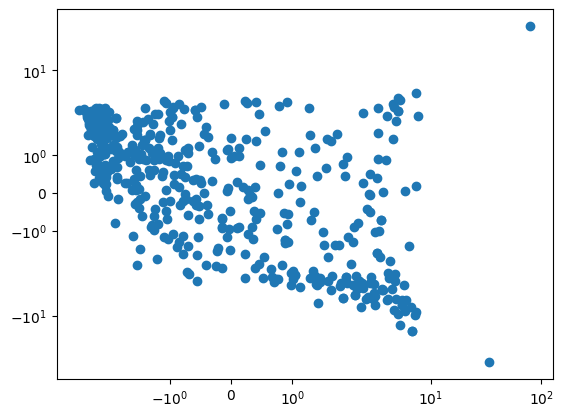

In [18]:
plt.scatter(Z.Z1, Z.Z2)
plt.xscale('symlog') # log pero sin eliminar valores <= 0
plt.yscale('symlog')

**Ejercicio 5**
Notamos que los valores se acumulan en un unico Cluster, exceptuando 2 outsiders que obligan a ver el grafico en escala logaritmica. Esto significa que 2 autovalores no nos alcanzaron para diferenciar categorias

**Ejercicio 6**

In [25]:
# Text vectorization using TF -IDF
vectorizer = TfidfVectorizer(analyzer=tokenize_and_stem ,
smooth_idf = False)
X = vectorizer.fit_transform(df_sports["content"])
df_sports_tfidf = pd.DataFrame(X.toarray (),
columns=vectorizer.get_feature_names_out ())

In [20]:
# Calculamos componentes principales con PCA de sklearn

n=2

pca = PCA(n_components=n)
Z = pd.DataFrame(pca.fit_transform(df_sports_tfidf))
Z.columns = ["Z" + str(i) for i in range(1,n+1)]  # Renombramos las columnas

**Ejercicio O1...**

**Ejercicio 7**

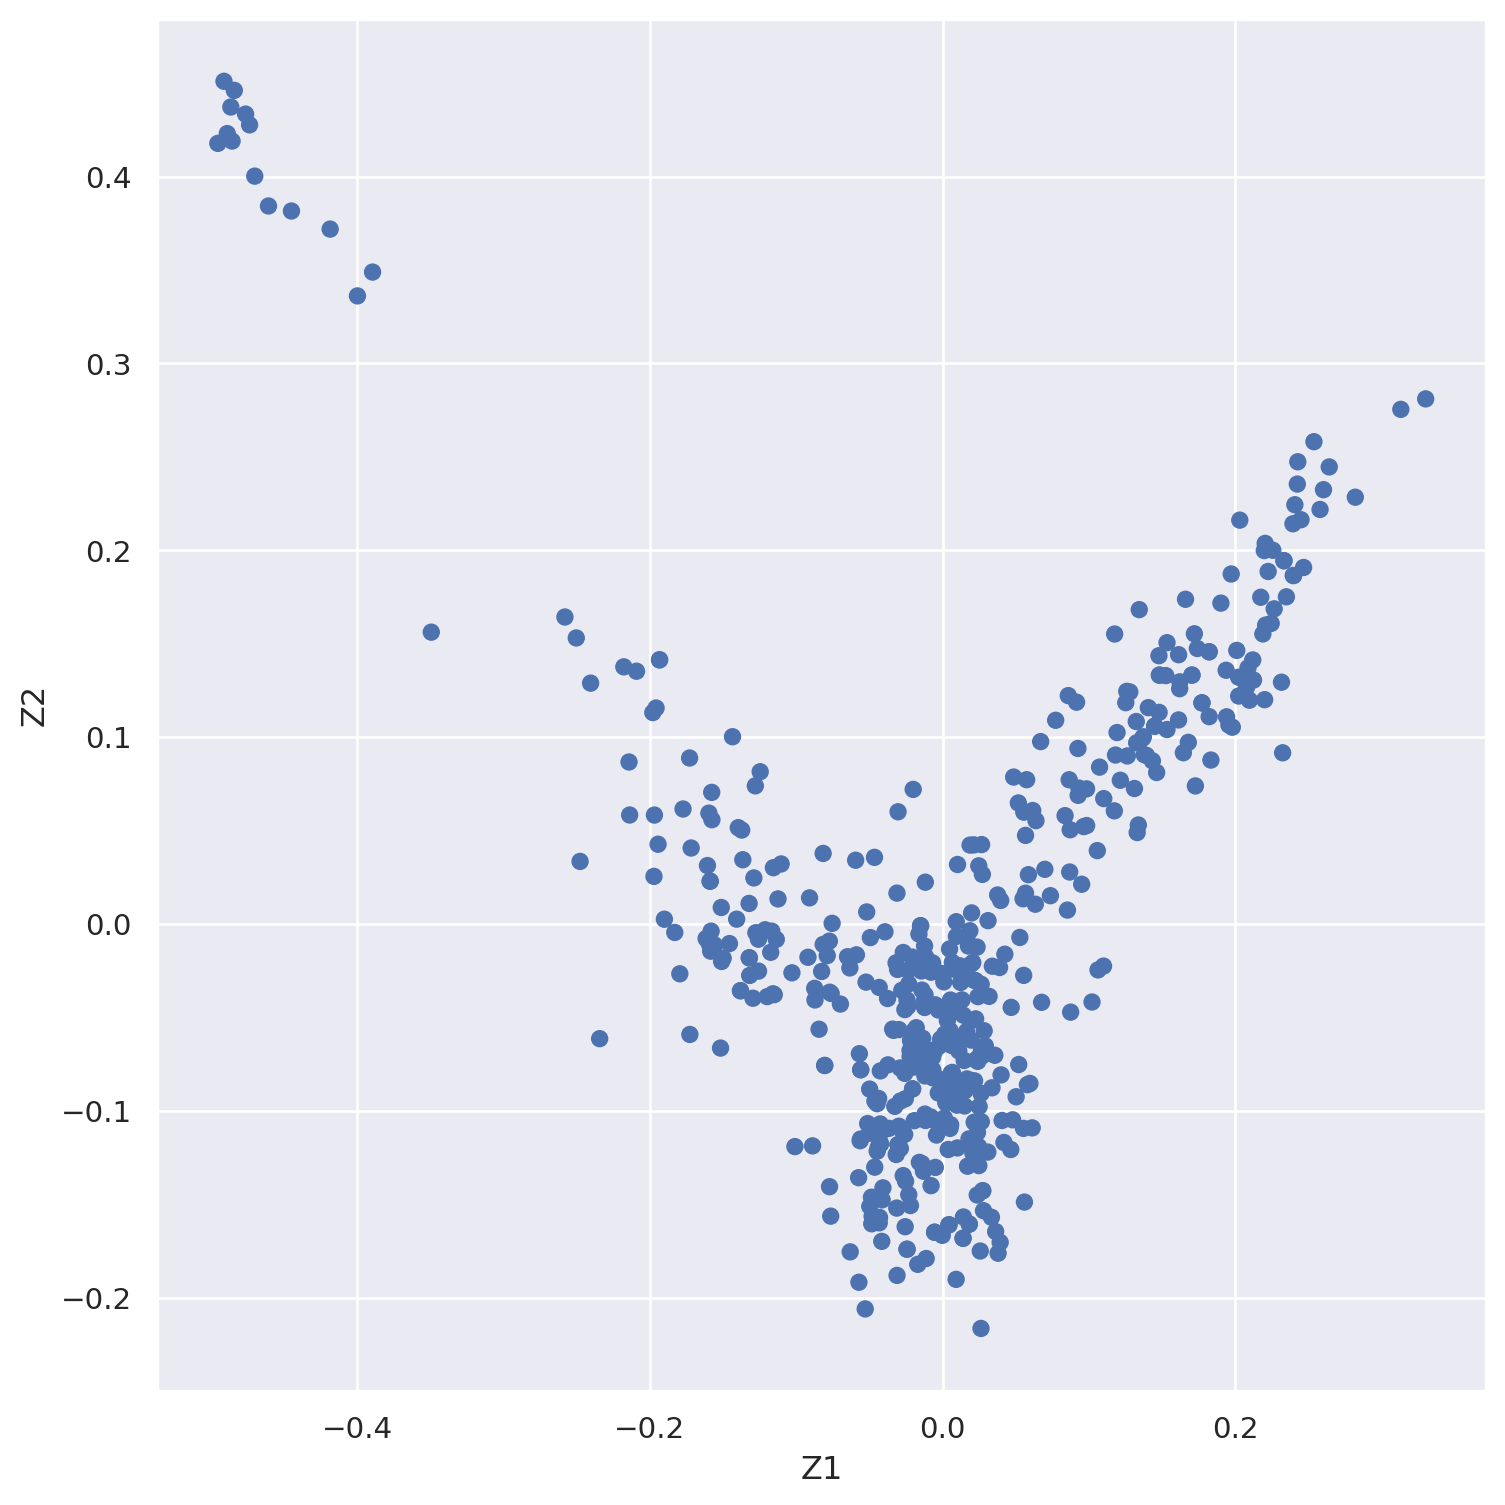

In [21]:
(
    so.Plot(Z, x="Z1", y="Z2")
    .add(so.Dot())
    .add(so.Text(valign="bottom"))
    .layout(size=(8,8))   # Conviene graficar en un cuadrado para ver correctamente las distancias 
)

Si bien no parece que los posibles clusters vayan a tener una forma esferica y isotropica, notamos que simultaneamente hay un grupo central muy denso y otros grupos perifericos poco densos, por lo que DBSCAN no podria separar los clusters. Entonces, probemos con Kmeans

**Ejercicio 8**

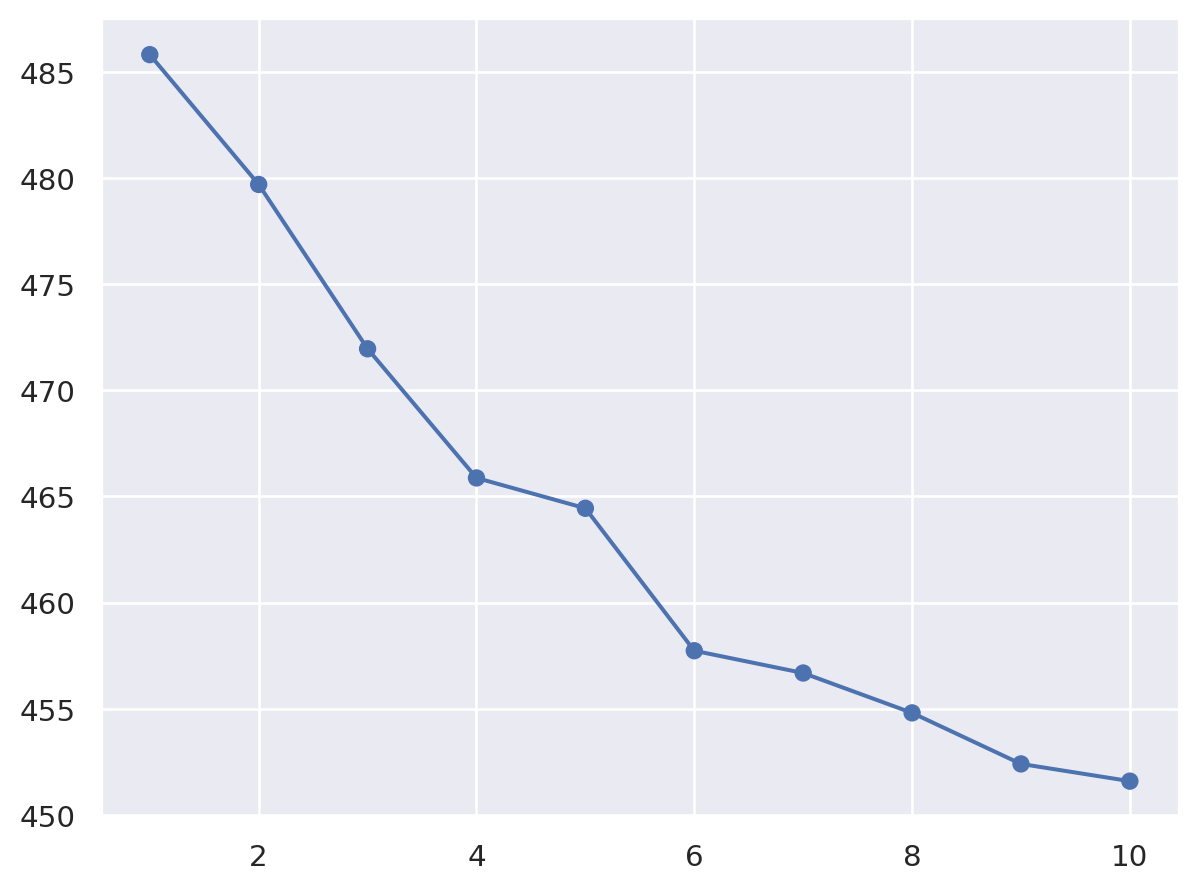

In [22]:
# Elección de la Cantidad de Clusters usando el método del Codo

inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_sports_tfidf)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
(
    so.Plot(x = k_values, y = inertias)
    .add(so.Line())
    .add(so.Dot())
)

El metodo nos da al 4 o al 6 como posibles candidatos a la cantidad de Clusters

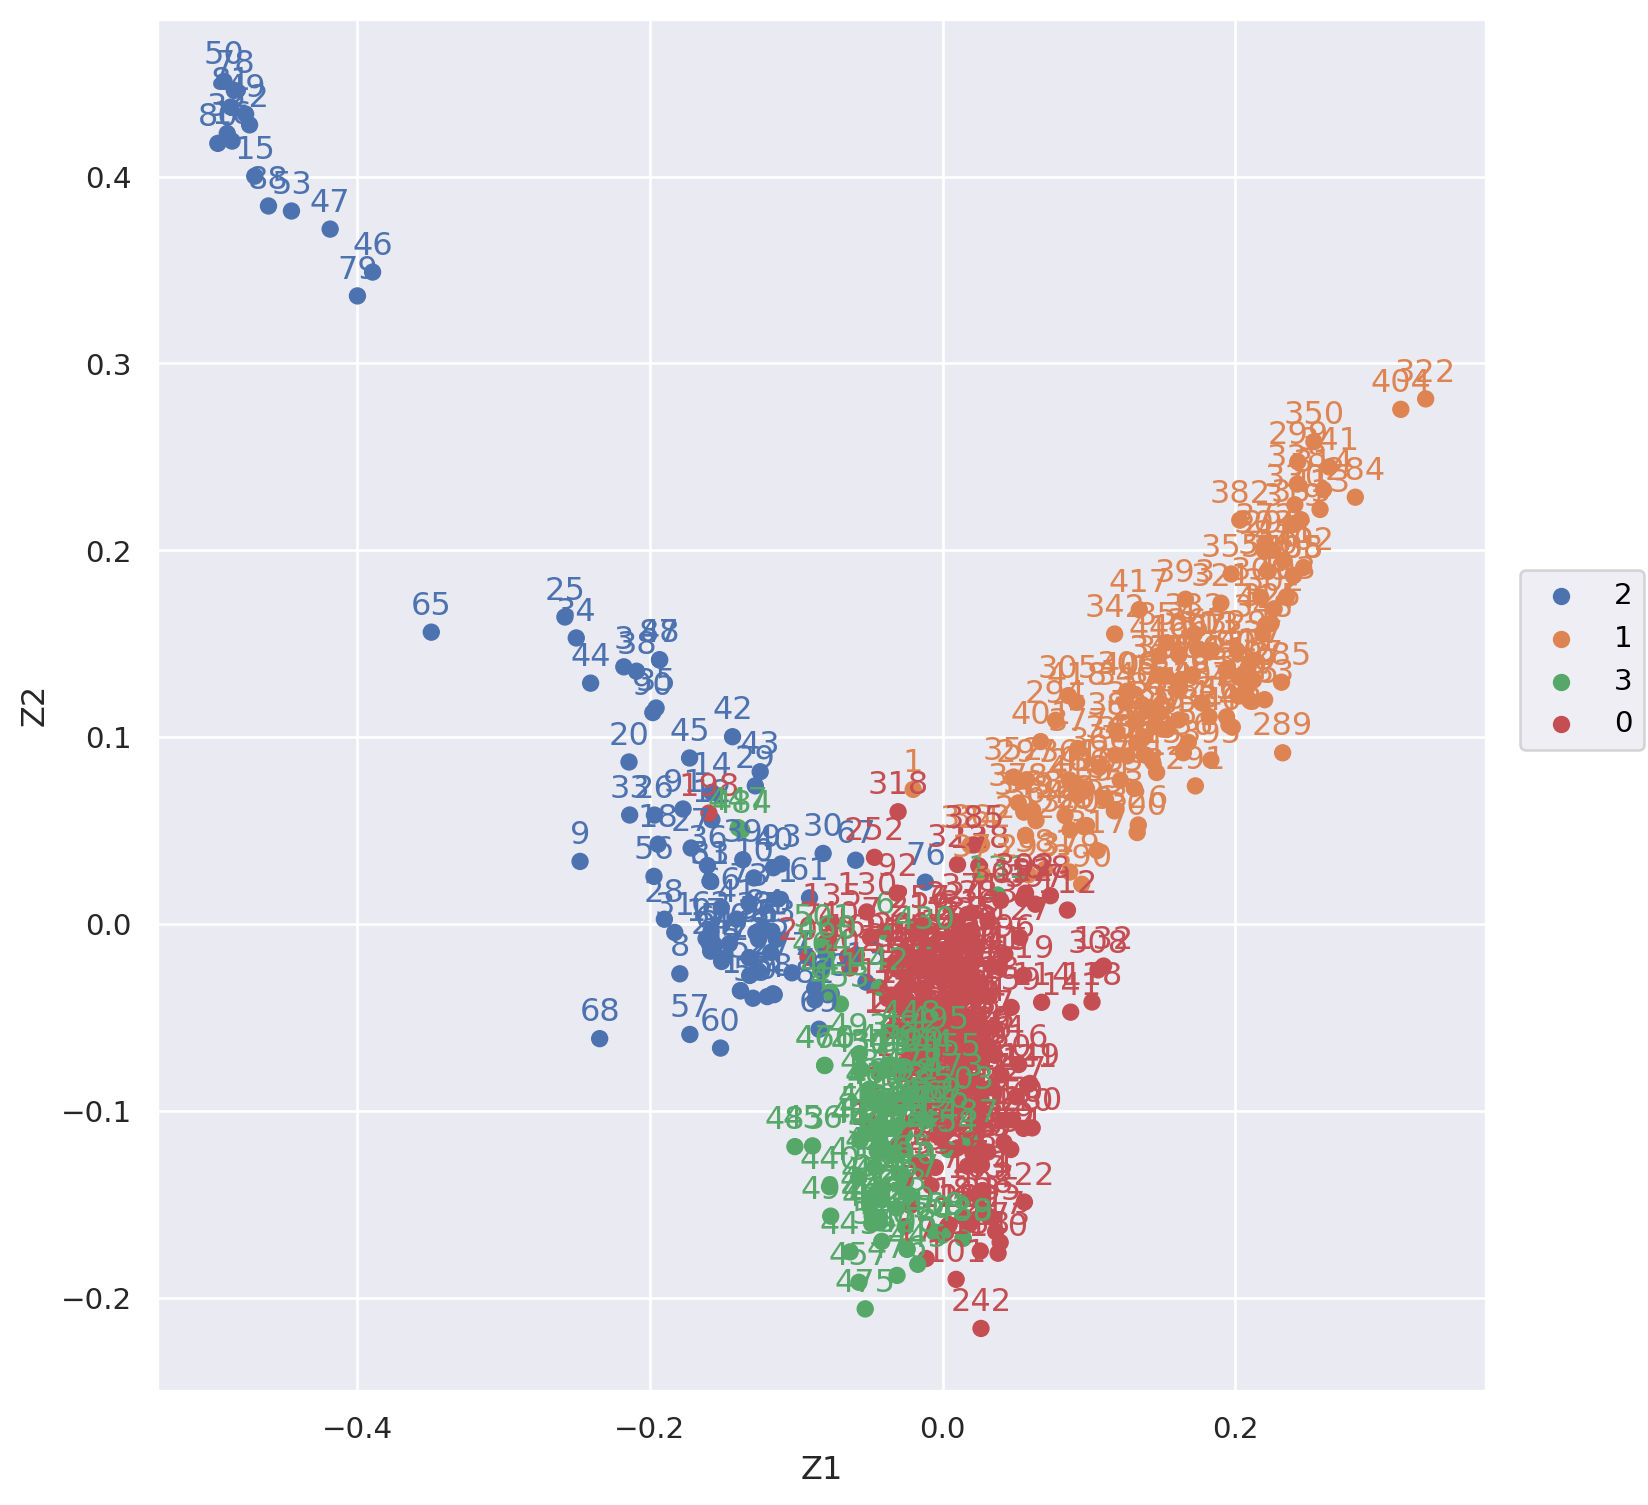

In [23]:
# KMeans con 4 Clusters

kmeans = KMeans(n_clusters=4, random_state=42)
etiquetas = kmeans.fit_predict(df_sports_tfidf)
(
    so.Plot(Z, x="Z1", y="Z2", color = etiquetas.astype("str"), text=Z.index)
    .add(so.Dot())
    .add(so.Text(valign="bottom"))
    .layout(size=(8,8))
)

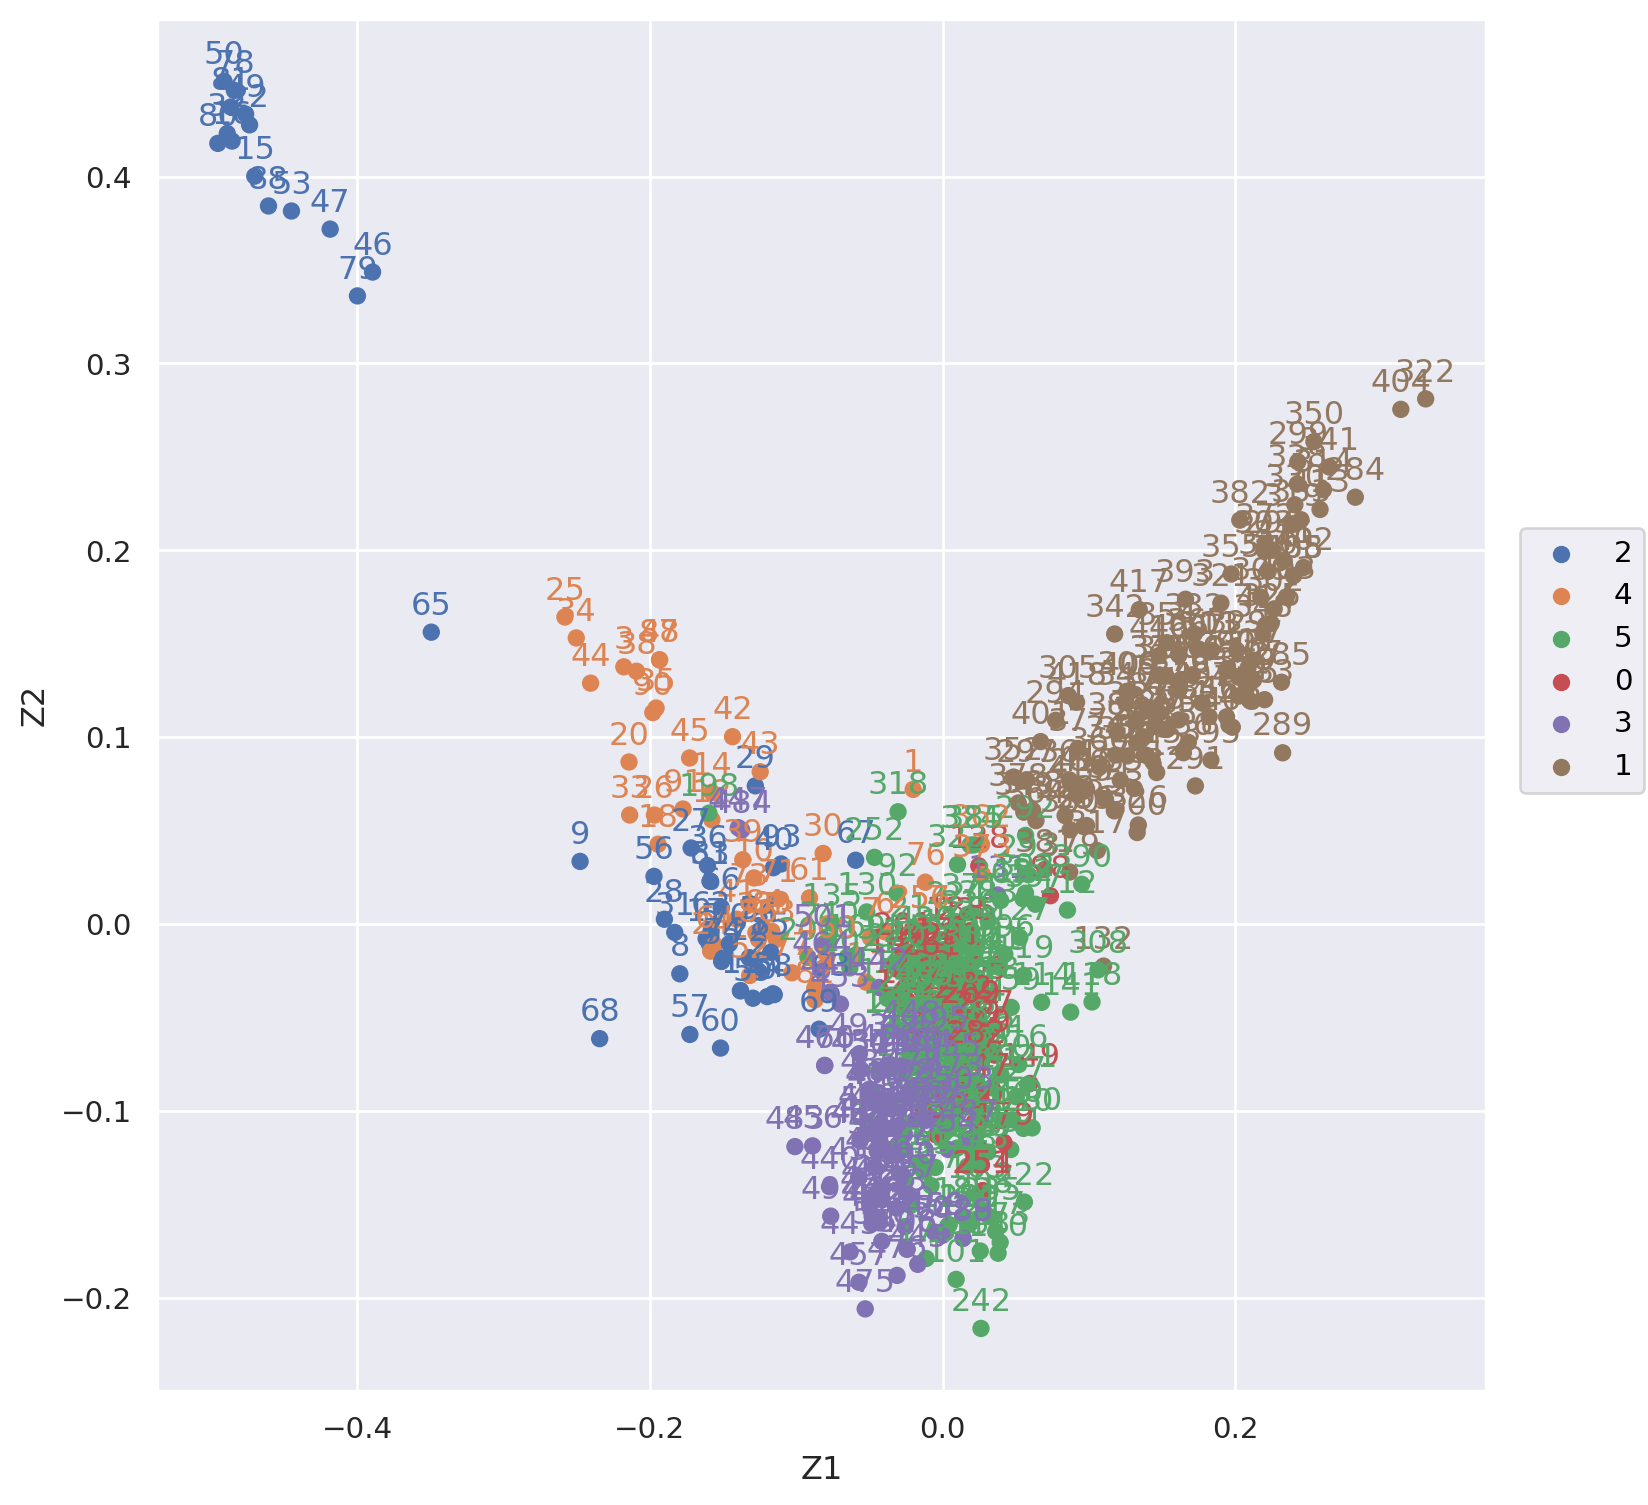

In [24]:
# KMeans con 6 Clusters

kmeans = KMeans(n_clusters=6, random_state=42)
etiquetas = kmeans.fit_predict(df_sports_tfidf)
(
    so.Plot(Z, x="Z1", y="Z2", color = etiquetas.astype("str"), text=Z.index)
    .add(so.Dot())
    .add(so.Text(valign="bottom"))
    .layout(size=(8,8))
)

**Ejercicio 9**
Comparando al de 6 Clusters con el de 4, la diferencia fundamental es separar el Cluster de la rama que va hacia Z1 negativo y también separar unos pocos elementos del que esta alrededor del 0,0. Al menos viendolo desde el grafico de la proyección en las 2 Componentes Principales, no parece que ninguna de estas separaciones vaya a ser significativamente distinta a su Cluster original, asi que nos quedamos con el de 4.

Exceptuando unos pocos casos aislado en dicha rama en Z1 negativo, los elementos en la separacion en 4 Clusters quedan cerca entre si en la proyección de 2 Componentes Principales